In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
import seaborn as sb
from lpf_nd import LPFunction as LPFM
from core import *

In [205]:
c1a = load('results/TrES_3b_color_wn_nomask_mc.npz')['chains']
c1b = load('results/TrES_3b_color_nomask_dw_mc.npz')['chains']
c2a = load('results/TrES_3b_color_wn_masked_mc.npz')['chains']
c2b = load('results/TrES_3b_color_masked_dw_mc.npz')['chains']

In [206]:
fc1a = c1a.reshape([-1,c1a.shape[2]])
fc1b = c1b.reshape([-1,c1b.shape[2]])
fc2a = c2a.reshape([-1,c2a.shape[2]])
fc2b = c2b.reshape([-1,c2b.shape[2]])

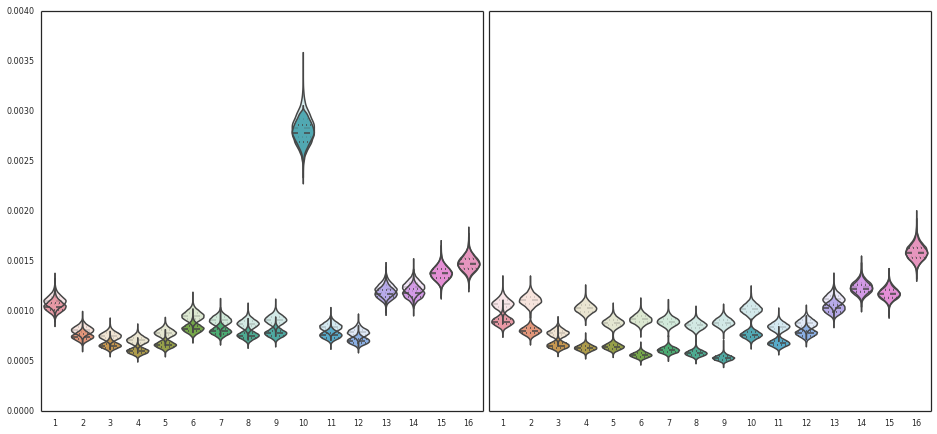

In [207]:
fig,ax = subplots(1,2,figsize=(13,6), sharey=True)
sb.violinplot(fc1a[::10,5::6], ax=ax[0], alpha=0.25)
sb.violinplot(fc1b[::10,-32:-16:], ax=ax[0])
sb.violinplot(fc2a[::10,5::6], ax=ax[1], alpha=0.25)
sb.violinplot(fc2b[::10,-32:-16:], ax=ax[1])
fig.tight_layout()

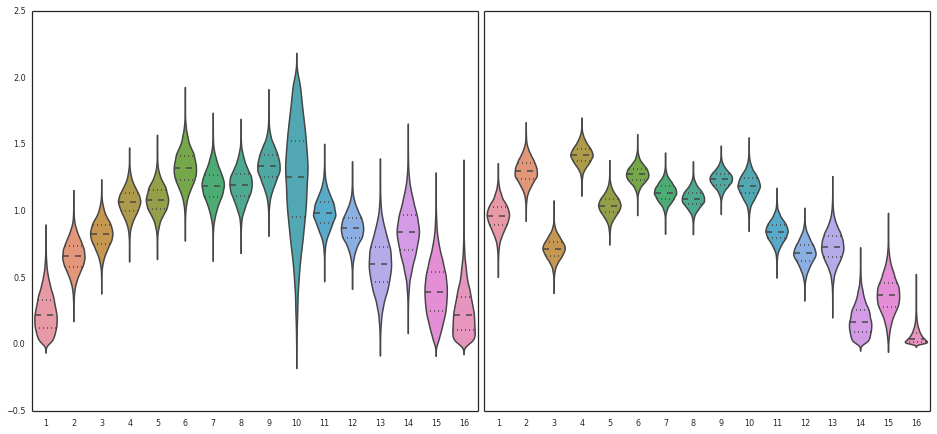

In [209]:
fig,ax = subplots(1,2,figsize=(13,6), sharey=True)
sb.violinplot(fc1b[::10,-16:], ax=ax[0]);
sb.violinplot(fc2b[::10,-16:], ax=ax[1]);
fig.tight_layout()

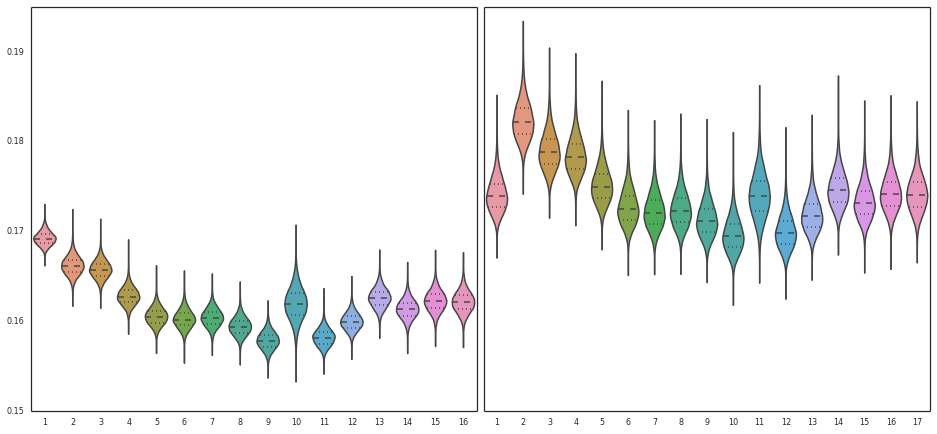

In [210]:
fig,ax = subplots(1,2,figsize=(13,6), sharey=True)
sb.violinplot(sqrt(fc1a[:,4::6]), ax=ax[0])
sb.violinplot(sqrt(fc1b[:,4:4+5*17:5]), ax=ax[1]);
fig.tight_layout()

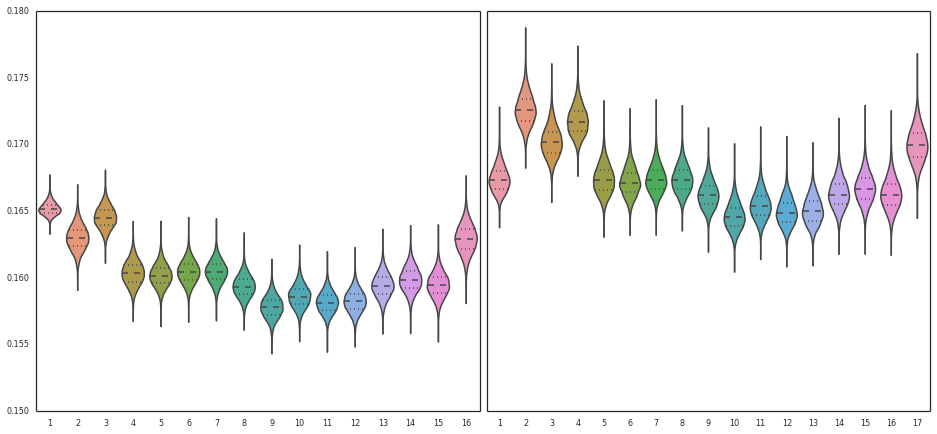

In [211]:
fig,ax = subplots(1,2,figsize=(13,6), sharey=True)
sb.violinplot(sqrt(fc2a[:,4::6]), ax=ax[0])
sb.violinplot(sqrt(fc2b[:,4:4+5*17:5]), ax=ax[1]);
fig.tight_layout()

In [73]:
df_aux = pd.read_hdf('results/light_curves.h5', 'aux')
df_lcb  = pd.read_hdf('results/light_curves.h5', 'final/bb_nomask')
df_lcn  = pd.read_hdf('results/light_curves.h5', 'final/nb_nomask')
msk = array(df_aux.bad_mask, dtype=np.bool)
        
flux = concatenate([array(df_lcb),array(df_lcn)], axis=1)[msk,:]
flt = [pb_filter_bb]+pb_filters_nb

In [77]:
lpf = LPFM(array(df_aux.mjd-56846+0.5)[msk], flux, df_aux.airmass[msk], 4)

In [178]:
mp = median(fc1b, 0)

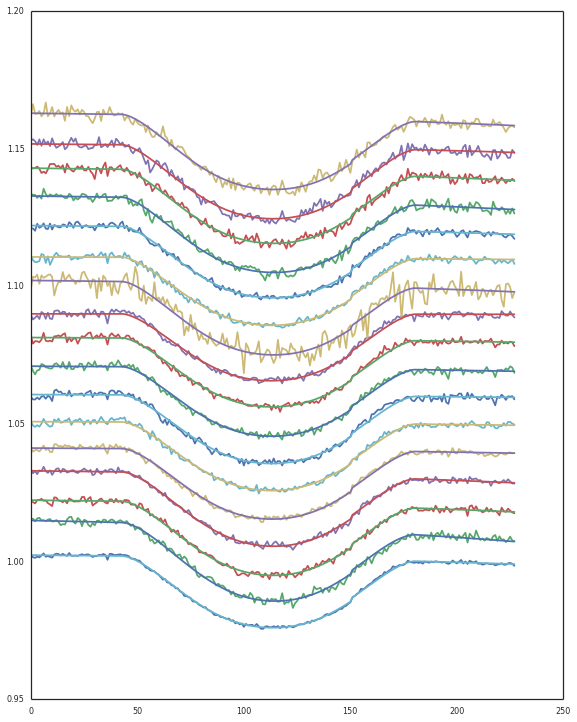

In [179]:
fig,ax = subplots(1,1,figsize=(8,10))
flux_m = lpf.compute_lc_model(mp)
plot(0.01*arange(17)+lpf.flux_o);
plot(0.01*arange(17)+flux_m);
fig.tight_layout()

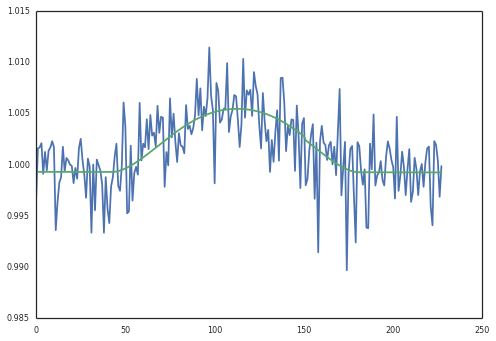

In [192]:
ro,rm = lpf.compute_flux_ratios(mp, 10, flux_m)
plot(ro)
plot(rm)

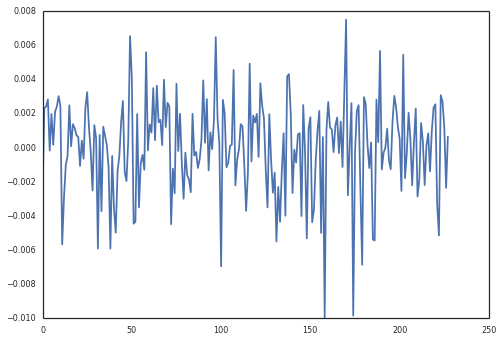

In [193]:
plot(ro-rm)

In [194]:
(ro-rm).std()

0.0027529427746839238

In [195]:
pid = 10
(lpf.flux_o[:,pid]-flux_m[:,pid]).std()

0.0028014310167212291

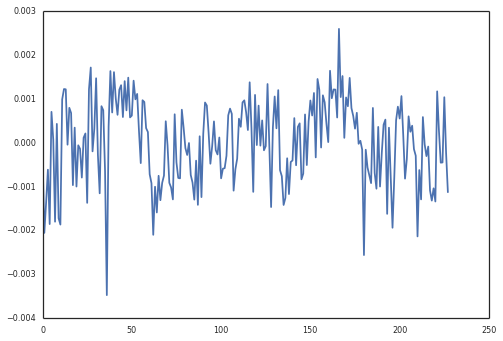

In [191]:
plot(lpf.flux_o[:,9]-flux_m[:,9])